# Generate random observation data for KMTNet broad-band (BVRI)
- Gregory S.H. Paek
- 22.10.05

In [1]:
import glob, os
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
import matplotlib as mpl
from astropy import units as u
import speclite.filters
import time
import multiprocessing
from itertools import repeat

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

## Useful functions

In [3]:
from helper import makeSpecColors
from helper import convert_flam2fnu
from helper import get_wollaeger
from helper import convert_app2abs
from helper import convert_abs2app
kncbtbl = get_wollaeger()
from helper import get_bandwidth_table
bdwtbl = get_bandwidth_table()
#	speclite
from helper import get_speclite_med
meds = get_speclite_med()
mlam = meds.effective_wavelengths
mbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Med']*u.Angstrom
from helper import get_speclite_sdss
sdss = get_speclite_sdss()
slam = sdss.effective_wavelengths
sbdw = bdwtbl['bandwidth'][bdwtbl['group']=='SDSS']*u.Angstrom
from helper import get_speclite_jc
jc = get_speclite_jc()
jclam = jc.effective_wavelengths
jcbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Johnson Cousin']*u.Angstrom
from helper import get_speclite_lsst
lsst = get_speclite_lsst()
lsstlam = lsst.effective_wavelengths
from helper import get_lsst_depth
from helper import get_kmtnet_depth
# lsstbdw = bdwtbl['bandwidth'][bdwtbl['group']
#
from helper import get_7dt_depth
from helper import get_7dt_broadband_depth
# dptbl = get_7dt_depth(exptime=180)
# dptbl = get_7dt_broadband_depth(exptime=180)

In [4]:
magoffset = -4.3

In [5]:
knsp = '../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.3_angle0_synphot_jc.ecsv'
intbl = ascii.read(knsp)
intbl[10:25]

t,B,V,R,I
d,mag(AB),mag(AB),mag(AB),mag(AB)
float64,float64,float64,float64,float64
0.297,-13.871,-13.471,-13.352,-13.050
0.324,-13.887,-13.524,-13.389,-13.105
0.354,-13.883,-13.565,-13.422,-13.155
0.386,-13.857,-13.598,-13.446,-13.194
0.42,-13.805,-13.623,-13.478,-13.229
0.459,-13.701,-13.639,-13.516,-13.269
0.5,-13.526,-13.641,-13.563,-13.319
0.545,-13.274,-13.611,-13.617,-13.382


- Synphot Table

In [6]:
def extract_param_kn_sim_cube(knsp):
	part = os.path.basename(knsp).split('_')

	if part[1] == 'TP':
		dshape = 'toroidal'
	elif part[1] == 'TS':
		dshape = 'spherical'
	else:
		dshape = ''

	#	Latitude
	if part[5] == 'wind1':
		lat = 'Axial'
	elif part[5] == 'wind2':
		lat = 'Edge'
	else:
		lat = ''

	#	Ejecta mass for low-Ye [solar mass]
	md = float(part[7].replace('md', ''))

	#	Ejecta velocity for low-Ye [N*c]
	vd = float(part[8].replace('vd', ''))

	#	Ejecta mass for high-Ye [solar mass]
	mw = float(part[9].replace('mw', ''))

	#	Ejecta velocity for high-Ye [N*c]
	vw = float(part[10].replace('vw', ''))

	#	Angle
	angle = float(part[11].replace('angle', ''))

	return dshape, lat, md, vd, mw, vw, angle

In [7]:
dshape, lat, md, vd, mw, vw, angle = extract_param_kn_sim_cube(knsp)
print(dshape, lat, md, vd, mw, vw, angle)

spherical Edge 0.1 0.3 0.1 0.3 0.0


- Depth Table

In [8]:
def calc_snr(m, ul, sigma=5):
	snr = sigma*10**((ul-m)/5)
	return snr

def convert_snr2magerr(snr):
	merr = 2.5*np.log10(1+1/snr)
	return merr

def calc_GaussianFraction(seeing, optfactor=0.6731, path_plot=None):
	import numpy as np
	import matplotlib.pyplot as plt
	from scipy.special import erf

	# seeing, optfactor= 1.5, 0.6731

	mu = 0.0
	# sigma = fwhm_seeing/2.355
	fwhm2sigma = seeing*2.355
	# optfactor = 0.6731
	sigma = fwhm2sigma*optfactor

	x = np.linspace(-8, 8, 1000)
	y = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(x-mu)**2 / (2 * sigma**2))
	y_cum = 0.5 * (1 + erf((x - mu)/(np.sqrt(2 * sigma**2))))

	indx_aperture = np.where(
		(x>-sigma*optfactor) &
		(x<+sigma*optfactor)
	)
	xaper = x[indx_aperture]
	yaper = y[indx_aperture]

	frac = np.sum(yaper)/np.sum(y) 
	# print(np.sum(y), np.sum(yaper), frac)

	if path_plot != None:
		plt.plot(x, y, alpha=0.5, label=f'PDF of N(0, {sigma:1.3f})', lw=5)
		plt.plot(xaper, yaper, alpha=1.0, label=f'Aperture ({frac*1e2:.1f}%)', lw=5,)
		plt.xlabel('x', fontsize=20)
		plt.ylabel('f(x)', fontsize=20)
		plt.legend(loc='lower center', fontsize=14)
		# plt.show()
		plt.savefig(path_plot, overwrite=True)
	else:
		pass

	return frac

def add_noise(mu, sigma, nseed, n=10, path_plot=None):
	"""
	mu, sigma = 17.5, 0.1
	n = 10
	"""
	from scipy.stats import norm
	import numpy as np
	
	try:
		x = np.arange(mu-sigma*n, mu+sigma*n, sigma*1e-3)
		y = norm(mu, sigma).pdf(x)

		if path_plot != None:
			resultlist = []
			for i in range(10000):
				xobs = np.random.choice(x, p=y/np.sum(y))
				# print(xobs)
				resultlist.append(xobs)
			plt.axvspan(xmin=mu-sigma, xmax=mu+sigma, alpha=0.5, color='tomato',)
			plt.axvline(x=mu, ls='--', alpha=1.0, color='tomato', lw=3)
			plt.plot(x, y, lw=3, alpha=0.75, color='grey')
			plt.hist(resultlist, lw=3, alpha=0.75, color='k', histtype='step', density=True)
			plt.xlabel(r'$\rm m_{obs}$')
			plt.plot(x, y)
			plt.savefig(path_plot, overwrite=True)
		else:
			pass
		#	more complicated choice with the fixed random seed
		np.random.seed(int((nseed+1)+(mu*1e2)))
		return np.random.choice(x, p=y/np.sum(y))
	except:
		# print('Something goes wrong (add_noise function)')
		return None

In [9]:
#	Setting
niteration = 10
d = 40*u.Mpc
aperfrac = calc_GaussianFraction(seeing=2.0, optfactor=1.0, path_plot=None)
times = np.unique(intbl['t'])
bfilterlist = [filte for filte in intbl.keys() if filte != 't']

t0 = time.time()
tablelist = []
for nseed in range(niteration):

	outbl = Table()
	# outbl.meta['distance'] = d
	outbl['seed'] = [nseed]*len(times)
	outbl['t'] = times

	for filte in bfilterlist:
		depth = get_kmtnet_depth(filte)*u.ABmag
		# depth = dptbl['5sigma_depth'][dptbl['name']==filte].item()*u.ABmag
		# outbl.meta[f'depth_{filte}'] = depth

		outbl[f'magabs_{filte}'] = (intbl[filte]+magoffset)*u.ABmag
		outbl[f'magapp_{filte}'] = convert_abs2app(outbl[f'magabs_{filte}'], d.to(u.pc).value)*u.ABmag
		outbl[f'snr_{filte}'] = calc_snr(outbl[f'magapp_{filte}'], depth.value)*aperfrac
		outbl[f'magerr_{filte}'] = convert_snr2magerr(outbl[f'snr_{filte}'])*u.ABmag
		outbl[f'magobs_{filte}'] = [add_noise(mu=m, sigma=merr, nseed=nseed, n=10, path_plot=None) for m, merr in zip(outbl[f'magapp_{filte}'], outbl[f'magerr_{filte}'])]*u.ABmag
		
		outbl[f'fnu_{filte}'] = outbl[f'magapp_{filte}'].to(u.uJy)
		outbl[f'fnuobs_{filte}'] = outbl[f'magobs_{filte}'].to(u.uJy)
		outbl[f'fnuerr_{filte}'] = outbl[f'fnu_{filte}']/outbl[f'snr_{filte}']

		outbl[f'detection_{filte}'] = [True if m<=depth.value else False for m in outbl[f'magobs_{filte}']]

		outbl[f'magabs_{filte}'].format = '1.3f'
		outbl[f'magapp_{filte}'].format = '1.3f'
		outbl[f'magerr_{filte}'].format = '1.3f'
		outbl[f'magobs_{filte}'].format = '1.3f'
		outbl[f'fnu_{filte}'].format = '1.3f'
		outbl[f'fnuobs_{filte}'].format = '1.3f'
		outbl[f'fnuerr_{filte}'].format = '1.3f'
		outbl[f'snr_{filte}'].format = '1.3f'

	#	Table of results --> tabelist
	tablelist.append(outbl)

comtbl = vstack(tablelist)
comtbl.meta['name'] = os.path.basename(knsp)
for filte in bfilterlist: comtbl.meta[f'depth_{filte}'] = get_kmtnet_depth(filte)*u.ABmag
comtbl.meta['distance'] = d
comtbl.meta['dshape'] = dshape
comtbl.meta['lat'] = lat
comtbl.meta['md'] = md
comtbl.meta['vd'] = vd
comtbl.meta['mw'] = mw
comtbl.meta['vw'] = vw
comtbl.meta['angle'] = angle

delt = time.time() - t0
print(f"Time ({niteration} iter.) : {delt:1.3f} sec")
print(f"Time/iteration  : {delt/niteration:1.3f} sec/iter.")

Time (10 iter.) : 1.335 sec
Time/iteration  : 0.133 sec/iter.


- Expected time

In [10]:
ndelt = delt/niteration
for nn in np.arange(0, 3+1, 1):
	print(f"10^{nn} iter. : {(ndelt*10**nn)/60:1.3f} min")


10^0 iter. : 0.002 min
10^1 iter. : 0.022 min
10^2 iter. : 0.222 min
10^3 iter. : 2.224 min


In [11]:
comtbl[10:30]
# comtbl.meta

seed,t,magabs_B,magapp_B,snr_B,magerr_B,magobs_B,fnu_B,fnuobs_B,fnuerr_B,detection_B,magabs_V,magapp_V,snr_V,magerr_V,magobs_V,fnu_V,fnuobs_V,fnuerr_V,detection_V,magabs_R,magapp_R,snr_R,magerr_R,magobs_R,fnu_R,fnuobs_R,fnuerr_R,detection_R,magabs_I,magapp_I,snr_I,magerr_I,magobs_I,fnu_I,fnuobs_I,fnuerr_I,detection_I
,d,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool
0,0.297,-18.171,14.840,54.214,0.020,14.843,4209.093,4197.492,77.639,True,-17.771,15.240,41.149,0.026,15.281,2911.255,2803.550,70.749,True,-17.652,15.359,41.671,0.026,15.392,2609.134,2529.386,62.613,True,-17.350,15.660,26.073,0.041,15.615,1976.594,2061.539,75.809,True
0,0.324,-18.187,14.824,54.612,0.020,14.821,4271.146,4280.922,78.209,True,-17.824,15.187,42.170,0.025,15.163,3057.590,3125.111,72.505,True,-17.689,15.321,42.403,0.025,15.350,2701.670,2630.579,63.714,True,-17.405,15.605,26.746,0.040,15.658,2079.889,1980.205,77.765,True
0,0.354,-18.183,14.827,54.531,0.020,14.824,4258.483,4268.244,78.093,True,-17.865,15.145,42.983,0.025,15.192,3176.513,3043.145,73.902,True,-17.722,15.288,43.051,0.025,15.266,2784.804,2841.193,64.687,True,-17.455,15.556,27.359,0.039,15.563,2176.382,2161.122,79.548,True
0,0.386,-18.157,14.853,53.879,0.020,14.845,4157.323,4189.172,77.160,True,-17.898,15.112,43.646,0.025,15.075,3275.242,3388.831,75.042,True,-17.746,15.265,43.515,0.025,15.255,2845.210,2870.533,65.384,True,-17.494,15.516,27.865,0.038,15.485,2257.612,2322.526,81.019,True
0,0.42,-18.105,14.905,52.598,0.020,14.921,3961.927,3905.916,75.325,True,-17.923,15.087,44.141,0.024,15.090,3349.995,3341.825,75.893,True,-17.778,15.233,44.162,0.024,15.271,2930.469,2829.241,66.357,True,-17.529,15.482,28.309,0.038,15.447,2330.031,2404.480,82.308,True
0,0.459,-18.001,15.009,50.132,0.021,15.004,3599.213,3616.243,71.794,True,-17.939,15.071,44.472,0.024,15.086,3400.518,3353.734,76.463,True,-17.816,15.194,44.951,0.024,15.169,3036.066,3105.999,67.542,True,-17.569,15.441,28.839,0.037,15.451,2418.236,2396.736,83.852,True
0,0.5,-17.826,15.184,46.256,0.023,15.163,3064.188,3125.882,66.244,True,-17.941,15.069,44.516,0.024,15.037,3407.167,3510.196,76.538,True,-17.863,15.147,45.942,0.023,15.190,3171.402,3046.564,69.031,True,-17.619,15.391,29.511,0.036,15.428,2532.137,2446.943,85.804,True
0,0.545,-17.574,15.436,41.184,0.026,15.433,2429.006,2436.301,58.979,True,-17.911,15.099,43.902,0.024,15.074,3313.829,3390.457,75.483,True,-17.917,15.093,47.085,0.023,15.070,3331.228,3403.049,70.749,True,-17.682,15.328,30.383,0.035,15.368,2683.990,2586.377,88.339,True


Text(0.5, 1.0, 't=0.125 days')

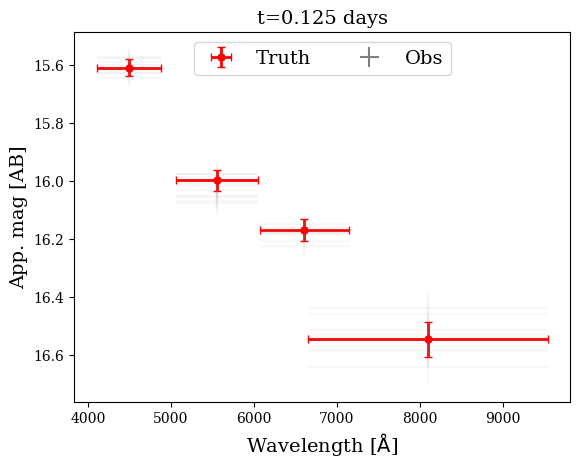

In [12]:
t = times[0]
# seeds = np.arange(0, 99+1, 1)
seeds = np.arange(0, 9, 1)
nseed = len(seeds)
# colors = makeSpecColors(nseed)

for ii, nseed in enumerate(seeds):
	magobslist = [comtbl[key][(comtbl['t']==t) & (comtbl['seed']==nseed)].item() for key in comtbl.keys() if 'magobs' in key]
	magerrlist = [comtbl[key][(comtbl['t']==t) & (comtbl['seed']==nseed)].item() for key in comtbl.keys() if 'magerr' in key]
	if ii == 0:
		magapplist = [comtbl[key][(comtbl['t']==t) & (comtbl['seed']==nseed)].item() for key in comtbl.keys() if 'magapp' in key]
		plt.errorbar(jclam, magapplist, xerr=jcbdw/2, yerr=magerrlist, marker='.', ms=10, capsize=3, elinewidth=2, c='red', label='Truth', ls='None', alpha=1.0)
	else:
		pass

	plt.errorbar(jclam, magobslist, xerr=jcbdw/2, yerr=magerrlist, ls='None', alpha=0.05, c='grey',)

xl, xr = plt.xlim()
yl, yu = plt.ylim()

plt.errorbar(0, 0, xerr=0, yerr=0, ls='None', alpha=1.0, c='grey', label='Obs')

plt.legend(loc='upper center', ncol=4, fontsize=14)
plt.xlim([xl, xr])
plt.ylim([yu, yl])
plt.xlabel(r'Wavelength [$\rm \AA$]', fontsize=14)
plt.ylabel('App. mag [AB]', fontsize=14)
plt.title(f't={t:1.3f} days')

# Iteration

- Setting

In [13]:
path_result = "../5.result/kn_sim_cube_obs"
if ~os.path.exists(path_result): os.system(f"mkdir {path_result}")

mkdir: ../5.result/kn_sim_cube_obs: File exists


In [14]:
# niteration = int(1e2)
niteration = int(1e0)
d = 40*u.Mpc
aperfrac = calc_GaussianFraction(seeing=2.0, optfactor=1.0, path_plot=None)

In [15]:
knsplist = sorted(glob.glob("../3.table/kn_sim_cube_synphot/Run_*_synphot_jc.ecsv"))
knsplist[:5]

['../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_jc.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle120_synphot_jc.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle150_synphot_jc.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle180_synphot_jc.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle30_synphot_jc.ecsv']

In [16]:
d = 120*u.Mpc

In [17]:
d = 40*u.Mpc

import test

t0 = time.time()
ncores = 3
# knsplist0 = knsplist[:5]

if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=ncores)  # 현재 시스템에서 사용 할 프로세스 개수
    # pool.map(test.run_table_routine, zip(knsplist0, repeat(niteration), repeat(magoffset), repeat(dptbl), repeat(slam), repeat(sbdw)))
    pool.starmap(test.run_table_routine4kmtnet, zip(knsplist, repeat(d), repeat(niteration), repeat(aperfrac), repeat(magoffset), repeat(jclam), repeat(jcbdw)))

    pool.close()
    pool.join()

delt = time.time() - t0
print(f"Time : {delt:1.3f} sec")

# run_table_routine(knsp, niteration, magoffset, dptbl, slam, sbdw)

Time : 317.686 sec


In [18]:
d = 80*u.Mpc

import test

t0 = time.time()
ncores = 3
# knsplist0 = knsplist[:5]

if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=ncores)  # 현재 시스템에서 사용 할 프로세스 개수
    # pool.map(test.run_table_routine, zip(knsplist0, repeat(niteration), repeat(magoffset), repeat(dptbl), repeat(slam), repeat(sbdw)))
    pool.starmap(test.run_table_routine4kmtnet, zip(knsplist, repeat(d), repeat(niteration), repeat(aperfrac), repeat(magoffset), repeat(jclam), repeat(jcbdw)))

    pool.close()
    pool.join()

delt = time.time() - t0
print(f"Time : {delt:1.3f} sec")

# run_table_routine(knsp, niteration, magoffset, dptbl, slam, sbdw)

Time : 337.903 sec


In [19]:
d = 120*u.Mpc

import test

t0 = time.time()
ncores = 3
# knsplist0 = knsplist[:5]

if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=ncores)  # 현재 시스템에서 사용 할 프로세스 개수
    # pool.map(test.run_table_routine, zip(knsplist0, repeat(niteration), repeat(magoffset), repeat(dptbl), repeat(slam), repeat(sbdw)))
    pool.starmap(test.run_table_routine4kmtnet, zip(knsplist, repeat(d), repeat(niteration), repeat(aperfrac), repeat(magoffset), repeat(jclam), repeat(jcbdw)))

    pool.close()
    pool.join()

delt = time.time() - t0
print(f"Time : {delt:1.3f} sec")

# run_table_routine(knsp, niteration, magoffset, dptbl, slam, sbdw)

Time : 353.782 sec


In [20]:
d = 160*u.Mpc

import test

t0 = time.time()
ncores = 3
# knsplist0 = knsplist[:5]

if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=ncores)  # 현재 시스템에서 사용 할 프로세스 개수
    # pool.map(test.run_table_routine, zip(knsplist0, repeat(niteration), repeat(magoffset), repeat(dptbl), repeat(slam), repeat(sbdw)))
    pool.starmap(test.run_table_routine4kmtnet, zip(knsplist, repeat(d), repeat(niteration), repeat(aperfrac), repeat(magoffset), repeat(jclam), repeat(jcbdw)))

    pool.close()
    pool.join()

delt = time.time() - t0
print(f"Time : {delt:1.3f} sec")

# run_table_routine(knsp, niteration, magoffset, dptbl, slam, sbdw)

Time : 367.154 sec


In [21]:
d = 200*u.Mpc

import test

t0 = time.time()
ncores = 3
# knsplist0 = knsplist[:5]

if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=ncores)  # 현재 시스템에서 사용 할 프로세스 개수
    # pool.map(test.run_table_routine, zip(knsplist0, repeat(niteration), repeat(magoffset), repeat(dptbl), repeat(slam), repeat(sbdw)))
    pool.starmap(test.run_table_routine4kmtnet, zip(knsplist, repeat(d), repeat(niteration), repeat(aperfrac), repeat(magoffset), repeat(jclam), repeat(jcbdw)))

    pool.close()
    pool.join()

delt = time.time() - t0
print(f"Time : {delt:1.3f} sec")

# run_table_routine(knsp, niteration, magoffset, dptbl, slam, sbdw)

Time : 369.530 sec
